# Exploring possible MH-mediated trimming

### How frequent do possible MH-mediated trims appear across V-J pairs?

In [6]:
library(data.table)
library(tidyverse)
library(cowplot)
options(repr.plot.width=12, repr.plot.height=9)

In [9]:
# this file was obtained from the scripts/explore_mh.R file
mh_freq = fread('_ignore/TRA_v_trim_j_gene_bordering_mh_vdjserver_annotations.tsv')

In [13]:
mh_freq[, pair_total := sum(N), by = .(v_gene, j_gene)]
mh_freq[, total := sum(N)]
mh_freq[, pair_freq := pair_total/total]

mh_summary = mh_freq[pair_freq > 0.0005, sum(N), by = .(v_gene, j_gene, pair_freq, total_bordering_mh)]
mh_summary[, freq := V1/sum(V1), by = .(v_gene, j_gene)]

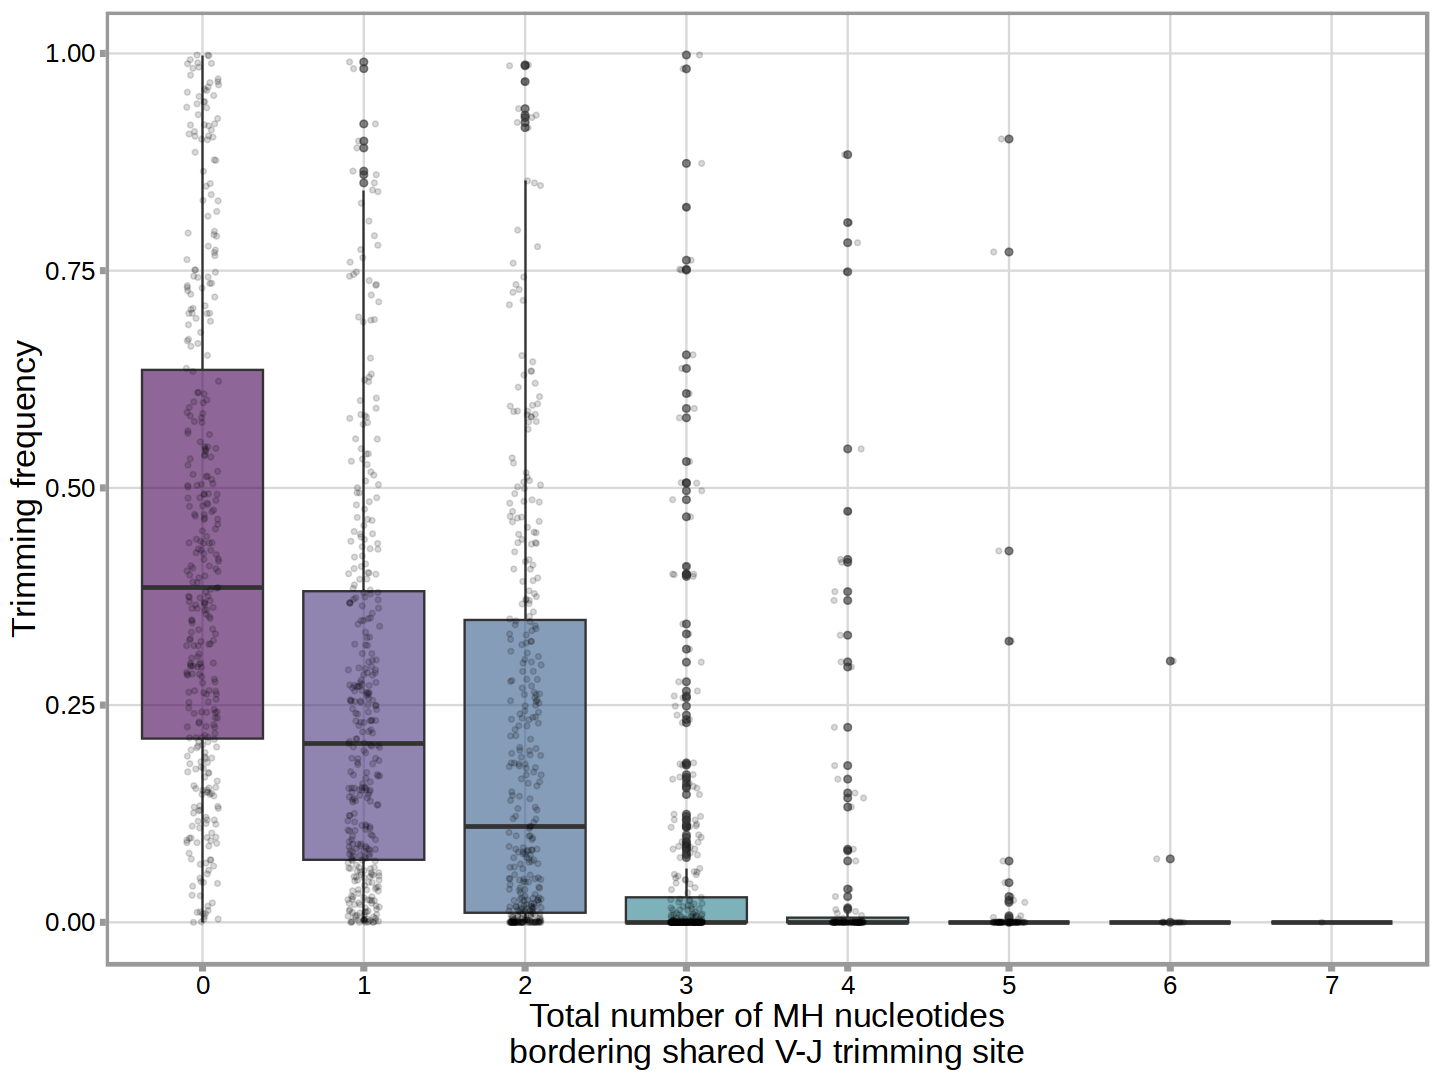

In [15]:
plot = ggplot(mh_summary)+
    geom_boxplot(aes(x = as.factor(total_bordering_mh), y = freq, fill = as.factor(total_bordering_mh)), alpha = 0.6)+
    geom_jitter(aes(x = as.factor(total_bordering_mh), y = freq), alpha = 0.15, size = 1, width = 0.1) +
    theme_cowplot(font_family = 'Arial') + 
    theme(text = element_text(size = 20), axis.text.x=element_text(size = 15), axis.text.y = element_text(size = 15), axis.line = element_blank(),axis.ticks = element_line(color = 'gray60', size = 1.5), legend.position = 'none') +
    scale_fill_viridis_d() +
    xlab('Total number of MH nucleotides\nbordering shared V-J trimming site') +
    ylab('Trimming frequency') +
    background_grid(major = 'xy')+
    panel_border(color = 'gray60', size = 1.5)
    
plot

### Does the frequency of these possible MH-mediated trimming scenarios correspond to the amount of MH present in the germline of each V-J pair?
For example, do V-J pairs that have lots of MH across trimming positions have a similar frequency of possible MH-mediated trimming scenarios?

In [22]:
germ = mh_freq[, .N, by = .(v_gene, j_gene, pair_freq, total_bordering_mh)]
germ[, germ_freq := N/sum(N), by = .(v_gene, j_gene)]

tog = merge(mh_summary, germ[pair_freq > 0.005])

In [26]:
mean = tog[, log10(mean(freq/germ_freq)), by = total_bordering_mh]
mean

total_bordering_mh,V1
<int>,<dbl>
0,-0.02903672
1,-0.15855425
2,0.15224666
3,0.42459590
4,0.39425504
5,-0.92577695
6,-Inf


Warning message:
“Removed 32 rows containing non-finite values (`stat_density()`).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


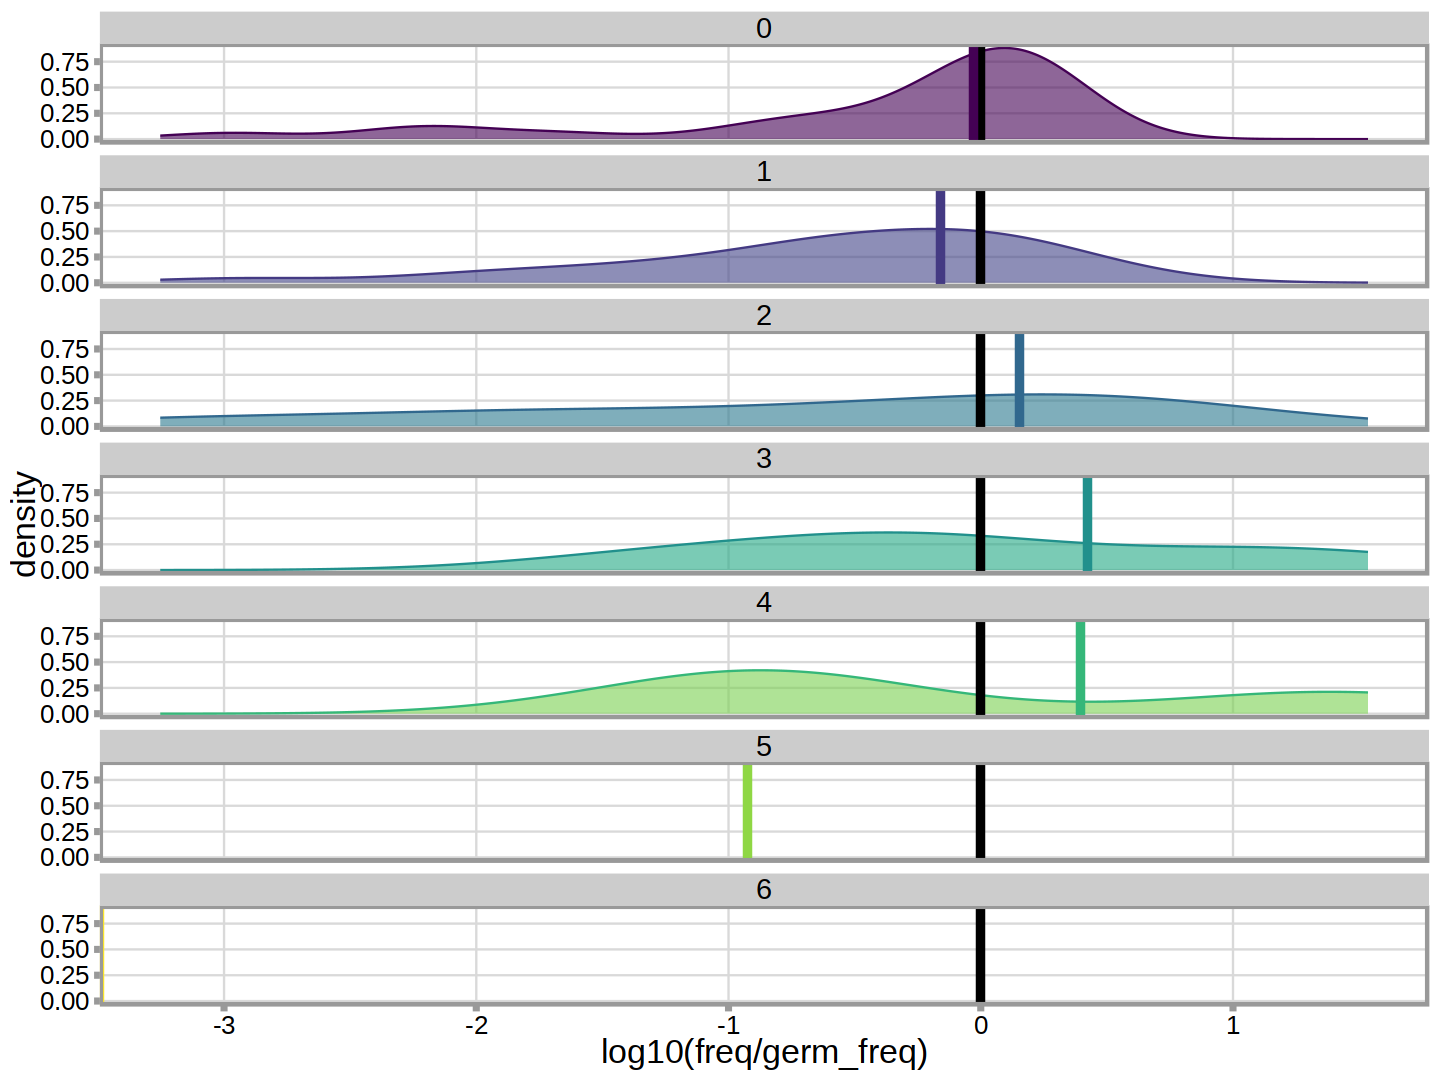

In [27]:
plot2 = ggplot(tog) +
    geom_density(aes(x = log10(freq/germ_freq), fill = as.factor(total_bordering_mh), color = as.factor(total_bordering_mh), group = total_bordering_mh), alpha = 0.6) +
    geom_vline(xintercept = 0, linewidth = 2) +
    facet_wrap(~total_bordering_mh, ncol = 1) +
    geom_vline(data = mean, aes(xintercept = V1, color = as.factor(total_bordering_mh)), linewidth = 2) +
    theme_cowplot(font_family = 'Arial') + 
    theme(text = element_text(size = 20), axis.text.x=element_text(size = 15), axis.text.y = element_text(size = 15), axis.line = element_blank(),axis.ticks = element_line(color = 'gray60', size = 1.5), legend.position = 'none') + 
    background_grid(major = 'xy') + 
    scale_color_viridis_d()+
    scale_fill_viridis_d()+
    panel_border(color = 'gray60', size = 1.5)

plot2

### Are possible MH-mediated trimming sites with more MH more frequent than we would expect if the V-J trimming events were independent?

In [28]:
subset = mh_freq[pair_freq > 0.0005]

# get probability if all trimming and gene choice events are independent
subset[, count_v_trim_v := sum(N), by = .(v_gene, v_trim)]
subset[, count_v := sum(N), by = .(v_gene)]
subset[, p_v_trim_v := count_v_trim_v/count_v]

subset[, count_j_trim_j := sum(N), by = .(j_gene, j_trim)]
subset[, count_j := sum(N), by = .(j_gene)]
subset[, p_j_trim_j := count_j_trim_j/count_j]

subset[, indep_trim_genechoice := p_v_trim_v * p_j_trim_j]

# get probability if all trimming (but not gene choice events) are independent
subset[, count_v_trim_vj := sum(N), by = .(v_gene, j_gene, v_trim)]
subset[, count_vj := sum(N), by = .(v_gene, j_gene)]
subset[, p_v_trim_vj := count_v_trim_vj/count_vj]

subset[, count_j_trim_vj := sum(N), by = .(v_gene, j_gene, j_trim)]
subset[, p_j_trim_vj := count_j_trim_vj/count_vj]

subset[, indep_trim := p_v_trim_vj * p_j_trim_vj]

# get probability if none of the events are independent
subset[, count_vj_trim_vj := sum(N), by = .(v_gene, j_gene, v_trim, j_trim)]
subset[, p_vj_trim_vj := count_vj_trim_vj/count_vj]

# normalize
#subset[, indep_trim := indep_trim/sum(indep_trim), by = .(v_gene, j_gene)]
#subset[, indep_trim_genechoice := indep_trim_genechoice/sum(indep_trim_genechoice), by = .(v_gene, j_gene)]

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 73461 rows containing non-finite values (`stat_smooth()`).”


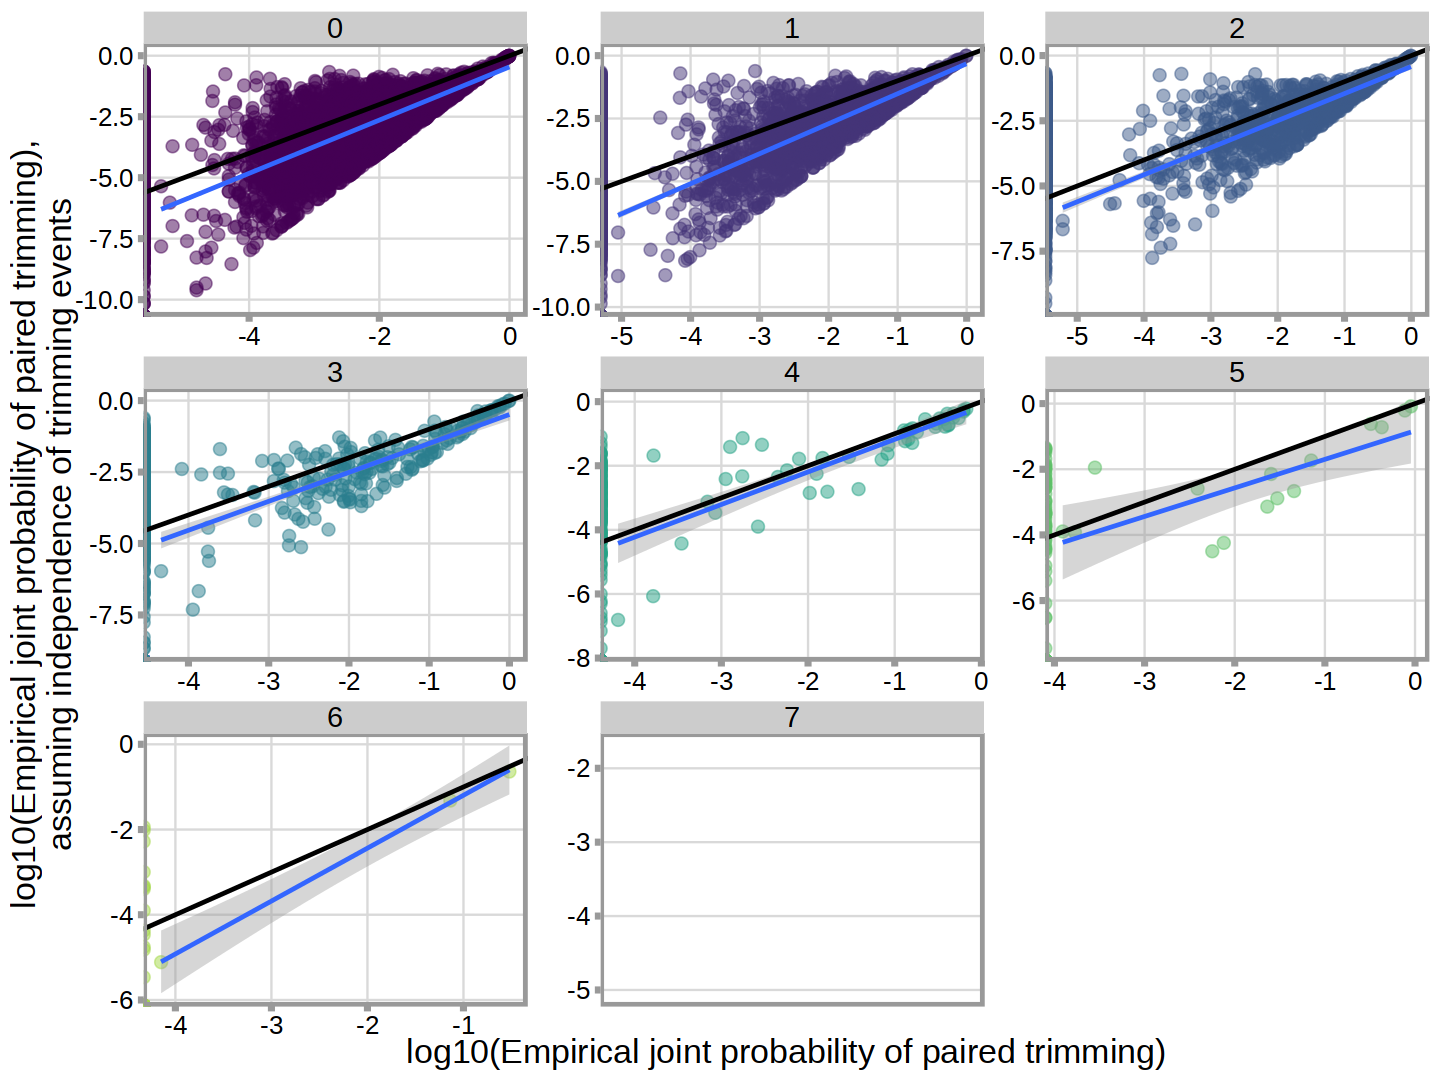

In [32]:
plot3 = ggplot(subset) +
    geom_point(aes(x = log10(p_vj_trim_vj), y = log10(indep_trim), color = total_bordering_mh), size = 3, alpha = 0.5) +
    geom_smooth(aes(x = log10(p_vj_trim_vj), y = log10(indep_trim)), method = 'lm') +
    facet_wrap(~total_bordering_mh, scales = 'free') +
    xlab('log10(Empirical joint probability of paired trimming)')+
    ylab('log10(Empirical joint probability of paired trimming),\nassuming independence of trimming events') +
    geom_abline(slope = 1, intercept = 0, size = 1)+
    theme_cowplot(font_family = 'Arial') + 
    theme(text = element_text(size = 20), axis.text.x=element_text(size = 15), axis.text.y = element_text(size = 15), axis.line = element_blank(),axis.ticks = element_line(color = 'gray60', size = 1.5), legend.position = 'none') + 
    background_grid(major = 'xy') + 
    scale_color_viridis_c()+
    panel_border(color = 'gray60', size = 1.5)

options(repr.plot.width=12, repr.plot.height=9)
plot3

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 73461 rows containing non-finite values (`stat_smooth()`).”


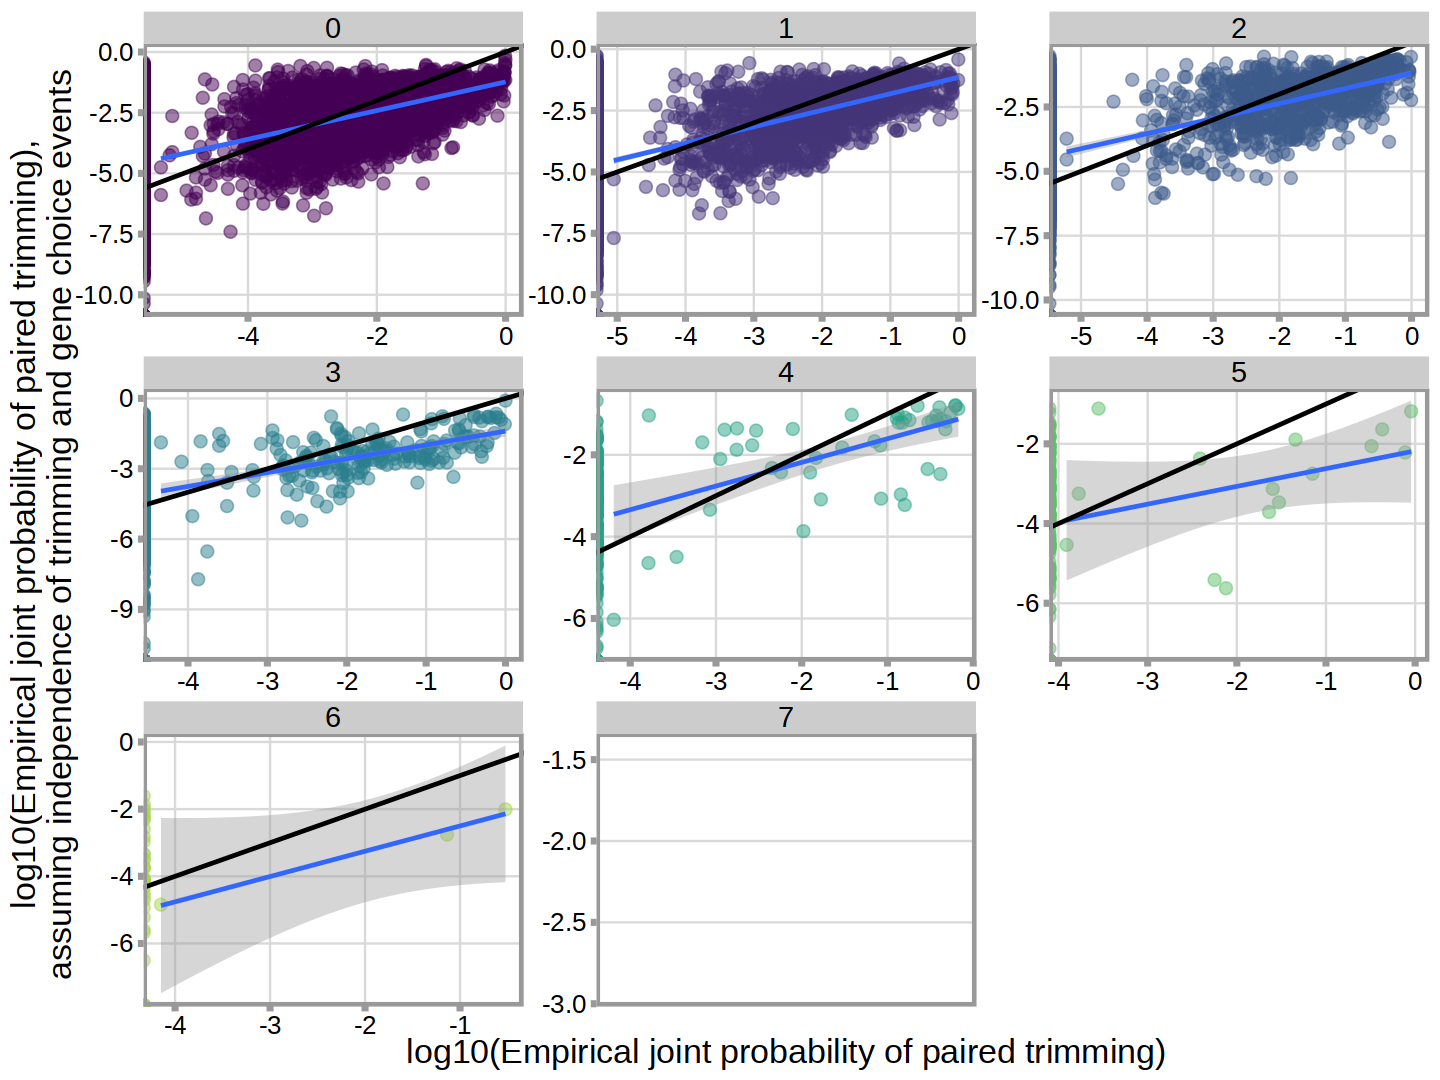

In [33]:
plot3.1 = ggplot(subset) +
    geom_point(aes(x = log10(p_vj_trim_vj), y = log10(indep_trim_genechoice), color = total_bordering_mh), size = 3, alpha = 0.5) +
    geom_smooth(aes(x = log10(p_vj_trim_vj), y = log10(indep_trim_genechoice)), method = 'lm') +
    facet_wrap(~total_bordering_mh, scales = 'free') +
    xlab('log10(Empirical joint probability of paired trimming)')+
    ylab('log10(Empirical joint probability of paired trimming),\nassuming independence of trimming and gene choice events') +
    geom_abline(slope = 1, intercept = 0, size = 1)+
    theme_cowplot(font_family = 'Arial') + 
    theme(text = element_text(size = 20), axis.text.x=element_text(size = 15), axis.text.y = element_text(size = 15), axis.line = element_blank(),axis.ticks = element_line(color = 'gray60', size = 1.5), legend.position = 'none') + 
    background_grid(major = 'xy') + 
    scale_color_viridis_c()+
    panel_border(color = 'gray60', size = 1.5)

options(repr.plot.width=12, repr.plot.height=9)
plot3.1

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 49394 rows containing non-finite values (`stat_smooth()`).”


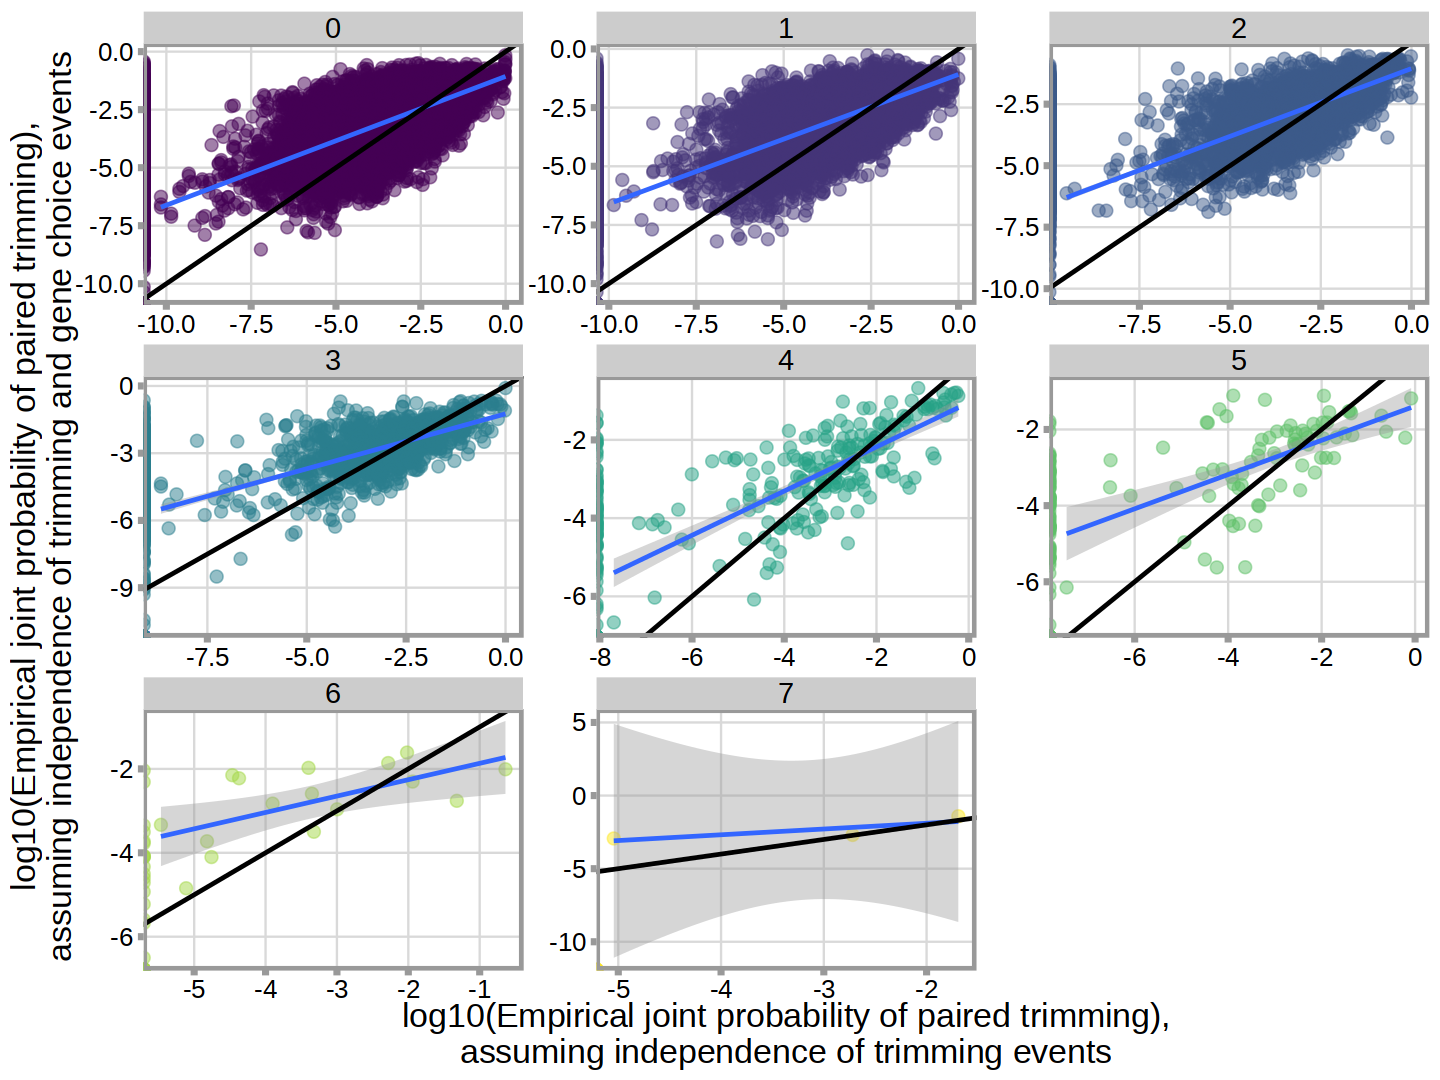

In [34]:
plot3.2 = ggplot(subset) +
    geom_point(aes(x = log10(indep_trim), y = log10(indep_trim_genechoice), color = total_bordering_mh), size = 3, alpha = 0.5) +
    geom_smooth(aes(x = log10(indep_trim), y = log10(indep_trim_genechoice)), method = 'lm') +
    facet_wrap(~total_bordering_mh, scales = 'free') +
    xlab('log10(Empirical joint probability of paired trimming),\nassuming independence of trimming events')+
    ylab('log10(Empirical joint probability of paired trimming),\nassuming independence of trimming and gene choice events') +
    geom_abline(slope = 1, intercept = 0, size = 1)+
    theme_cowplot(font_family = 'Arial') + 
    theme(text = element_text(size = 20), axis.text.x=element_text(size = 15), axis.text.y = element_text(size = 15), axis.line = element_blank(),axis.ticks = element_line(color = 'gray60', size = 1.5), legend.position = 'none') + 
    background_grid(major = 'xy') + 
    scale_color_viridis_c()+
    panel_border(color = 'gray60', size = 1.5)

options(repr.plot.width=12, repr.plot.height=9)
plot3.2